<p> Segunda Libreta sobre el trabajo de investigación: </p>

<center>

<p> 
<b>
"Estimación de la evapotranspiración espacio-temporal en arrozales usando imágenes satelitales, Departamento de Lambayeque" 
</b>
</p>

</center>

Autor: Cesar Vilca

Marzo, 2022

# Balance de Energía Superficial - Modelo METRIC

Satellite-Based Energy Balance for Mapping Evapotranspiration With Internalized Calibration (METRIC)

- METRIC is an image-processing model for calculating ET as a residual of the surface energy balance. 
- METRIC was developed by the University of Idaho for application to Landsat satellite imagery to maximize ET product resolution (30 m).
- METRIC uses as its foundation the pioneering SEBAL energy balance process developed in the Netherlands by Bastiaanssen et al. . 

## Inicio

Ejecutar todas las celdas ubicadas en esta sección para su uso posterior:
- Ingreso de creedenciales para usar Earth Engine en Colab (importa `ee` y login)
- Importar librerías como `geemap`, `pandas`, `matplotlib` entre otras.
- Ejecutar funciones realizadas para agilizar procesos repetitivos en ciertas ocasiones.

### Librerías

In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt

# gee
import ee
import geemap
import geemap.colormaps as cmp # Paletas para visualización de imágenes (cm se confunde con matplotlib)

# geemap.cartoee
%pylab inline 
from geemap import cartoee

ee.Initialize()

# Importar funciones de funciones.py
from funciones import *

Populating the interactive namespace from numpy and matplotlib


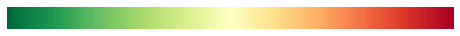

In [2]:
# Establecer una paleta
paleta = cmp.palettes.RdYlGn_r

# Ver una paleta
cmp.plot_colormap('RdYlGn_r', width=8.0, height=0.4, orientation='horizontal')

### Assets

Departamentos, Provincias y Distritos
- Distrito seleccionado: **Ferreñafe**

In [3]:
# Ejemplo de filtrado

# Assets
asset_dept = ee.FeatureCollection('users/CesarVilca/departamentos')
asset_prov = ee.FeatureCollection('users/CesarVilca/provincias')
asset_dist = ee.FeatureCollection('users/CesarVilca/distritos')

# Filtrado
deptSelectedName = 'LAMBAYEQUE'
provSelectedName = 'FERREÑAFE' # 'FERREÑAFE' 'CHICLAYO'
distSelectedName = 'FERREÑAFE' # 'FERREÑAFE' 'CHONGOYAPE'

dept_fcol = asset_dept.filterMetadata('DEPARTAMEN', 'equals', deptSelectedName)
prov_fcol = asset_prov.filterMetadata('PROVINCIA', 'equals', provSelectedName)
dist_fcol = asset_dist.filterMetadata('DISTRITO', 'equals', distSelectedName)

# ROI Caja
roi = dist_fcol.geometry().bounds()

empty = ee.Image().paint(dist_fcol, 2,2)
empty2 = ee.Image().paint(roi, 2, 2)

# Visualización
Map = geemap.Map(layer_ctrl = True) 
Map.centerObject(dist_fcol, 9)

Map.addLayer(dept_fcol, {'color':'red'}, f'Departamento {deptSelectedName}')
Map.addLayer(prov_fcol, {'color':'green'}, f'Provincia {provSelectedName} ')
Map.addLayer(dist_fcol, {'color':'blue'}, f'Distrito {distSelectedName}')

# Bordes
Map.addLayer(empty , {}, 'Distrito Seleccionado')
Map.addLayer(empty2, {}, 'Limites')

Map

# Zona de evaluación: Inicio Chongoyape
# parcelas_chongoyape = ee.FeatureCollection("users/CesarVilca/parcelas_chongoyape")
# parcelas_chongoyape.geometry().centroid().coordinates().getInfo()

Map(center=[-6.6205221157277006, -79.79111975903714], controls=(WidgetControl(options=['position', 'transparen…

In [4]:
ruta_ferrenafe = 'files/Ferreñafe_areas.shp'

predios_agricolas = geemap.shp_to_ee(ruta_ferrenafe)
predios_vis = ee.Image().paint(predios_agricolas, 1, 1) # Para visualización con geemap

predios_bound = predios_agricolas.geometry().bounds()
predios_bound_vis = ee.Image().paint(predios_bound, 1, 1) # Para visualización con geemap

type(predios_agricolas)

ee.featurecollection.FeatureCollection

## Balance de energía superficial

### Radiación Neta

#### Inputs

In [5]:
# Inputs
# Ojo: El mapa Aspect no se puede obtener en los límites -> usar áreas mayores a la que necesitas
dem = ee.Image("USGS/SRTMGL1_003").clip(roi) 

img_ee = ee.Image('LANDSAT/LC09/C02/T1/LC09_010065_20220403').clip(roi) # 2021-11-02
# img_ee = ee.Image(img_id).clip(roi)
img_toa = convert_RAW_to_TOA(img_ee)

img_date = img_ee.date().format('YYYY-MM-dd').getInfo()

# Radiación Neta: ['R_n', 'R_s_in', 'R_l_in', 'R_l_out']
R_n, img_sr_tasumi, img_albedo, img_ndvi, img_lai, cos_theta_rel, t_sw, e_0, d2, ts, doy = getRadiacionNeta(img_ee, roi, dem) 
d2 = d2.getInfo() # Inverso de la distancia solar 

img_date

'2022-04-03'

In [6]:
R_n_stats = get_stats(R_n.select('R_n'), predios_agricolas, 10, img_date)
print(R_n_stats)

                              0
Fecha                2022-04-03
Media                565.574045
Mediana              563.544963
Moda                  555.51449
Desviación Estándar   19.226316
Mínimo               517.420714
Máximo               651.915001


In [7]:
# Visualización con geemap
Map = geemap.Map()#height='800px') 
Map.centerObject(predios_bound, 16)

Map.addLayer(img_toa.clip(predios_bound), {'min':0,
                                           'max':0.3,
                                           'bands':['B4','B3','B2']}, 'RGB TOA')

vis_params_R_n = {'min': R_n_stats[0]['Mínimo'],
                  'max': R_n_stats[0]['Máximo'], 
                  'palette':cmp.palettes.RdYlGn_r}

Map.addLayer(R_n.select('R_n').clip(predios_agricolas), vis_params_R_n, 'R_n') 

Map.add_colorbar(vis_params_R_n, label="R_n [W/m²]", orientation="vertical")

Map

Map(center=[-6.600543783995576, -79.77983439983308], controls=(WidgetControl(options=['position', 'transparent…

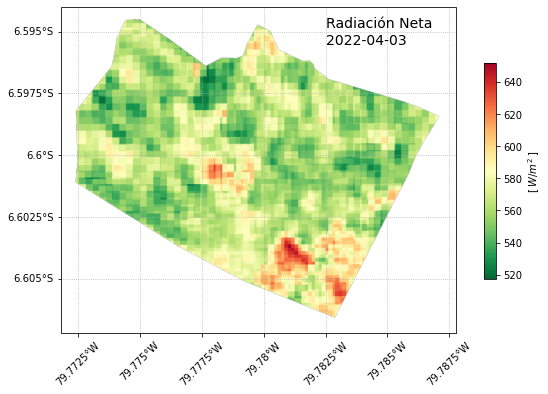

In [10]:
fig = plt.figure(figsize=(8,6))

zoom_region = [-79.787761, -6.607186, -79.771781, -6.593991]

# plot the result with cartoee using a PlateCarre projection (default)
ax = cartoee.get_map(
    R_n.select('R_n').clip(predios_agricolas),
    region=zoom_region,
    vis_params=vis_params_R_n)

cb = cartoee.add_colorbar(ax, vis_params=vis_params_R_n, loc='right', label="$[\; W/m^2 \;]$")

cartoee.add_gridlines(ax, interval=0.0025, xtick_rotation=45, linestyle=":")

# ax.set_title(label='Albedo, 2022-04-03')#, fontsize=15)

ax.text(-79.7825, -6.5955, f'Radiación Neta\n{img_date}', fontsize=14)


plt.show()

#### Radiación de onda corta entrante $R_{S\downarrow}$

In [28]:
R_s_in = R_n.select('R_s_in') # ['R_n', 'R_s_in', 'R_l_in', 'R_l_out']

In [34]:
R_s_in_stats = get_stats(R_s_in, predios_agricolas, 10, img_date)
print(R_s_in_stats)

                              0
Fecha                2022-04-03
Media                 792.92623
Mediana              793.729278
Moda                 791.212771
Desviación Estándar   10.828874
Mínimo               758.147781
Máximo               826.897789


In [33]:
Map = geemap.Map()
Map.centerObject(predios_agricolas, 16)

Map.addLayer(img_toa.clip(predios_bound), {'min':0,
                                           'max':0.3,
                                           'bands':['B4','B3','B2']}, 'RGB TOA')
vis_params_rsin = {'min':758.1477808728148,
                   'max':826.8977888261893,
                   'palette':cmp.palettes.RdYlGn_r}

Map.addLayer(R_s_in.clip(predios_agricolas), vis_params_rsin, 'R_s_in')
Map.add_colorbar(vis_params_rsin, label="R_s_in [W/m²]", orientation="vertical")

Map

Map(center=[-6.600211501838919, -79.78018963282872], controls=(WidgetControl(options=['position', 'transparent…

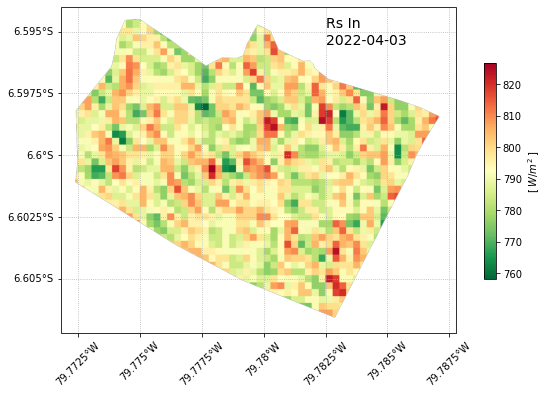

In [36]:
fig = plt.figure(figsize=(8,6))

zoom_region = [-79.787761, -6.607186, -79.771781, -6.593991]

# plot the result with cartoee using a PlateCarre projection (default)
ax = cartoee.get_map(
    R_s_in.clip(predios_agricolas),
    region=zoom_region,
    vis_params=vis_params_rsin)

cb = cartoee.add_colorbar(ax, vis_params=vis_params_rsin, loc='right', label="$[\; W/m^2 \;]$")

cartoee.add_gridlines(ax, interval=0.0025, xtick_rotation=45, linestyle=":")

# ax.set_title(label='Albedo, 2022-04-03')#, fontsize=15)

ax.text(-79.7825, -6.5955, f'Rs In \n{img_date}', fontsize=14)


plt.show()

#### Radiación de onda larga entrante $R_{L\downarrow}$

In [37]:
R_l_in = R_n.select('R_l_in') # ['R_n', 'R_s_in', 'R_l_in', 'R_l_out']

In [39]:
R_l_in_stats = get_stats(R_l_in, predios_agricolas, 10, img_date)
print(R_l_in_stats)

                              0
Fecha                2022-04-03
Media                304.163551
Mediana              303.440159
Moda                 303.184361
Desviación Estándar      2.5762
Mínimo               301.065511
Máximo               325.162741


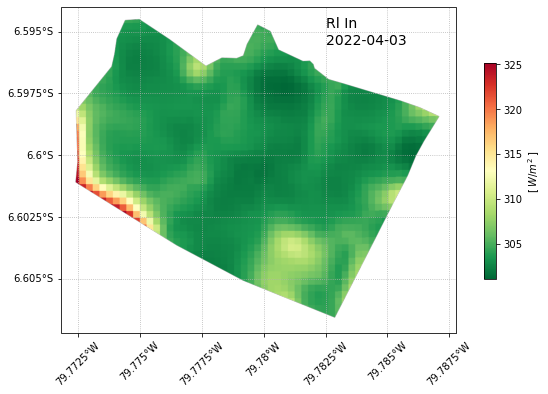

In [43]:
fig = plt.figure(figsize=(8,6))

zoom_region = [-79.787761, -6.607186, -79.771781, -6.593991]
vis_params_rlin = {'min':R_l_in_stats[0]['Mínimo'],
                   'max':R_l_in_stats[0]['Máximo'],
                   'palette':cmp.get_palette(cmap_name='RdYlGn_r')}

# plot the result with cartoee using a PlateCarre projection (default)
ax = cartoee.get_map(
    R_l_in.clip(predios_agricolas),
    region=zoom_region,
    vis_params=vis_params_rlin)

cb = cartoee.add_colorbar(ax, vis_params=vis_params_rlin, loc='right', label="$[\; W/m^2 \;]$")

cartoee.add_gridlines(ax, interval=0.0025, xtick_rotation=45, linestyle=":")

# ax.set_title(label='Albedo, 2022-04-03')#, fontsize=15)

ax.text(-79.7825, -6.5955, f'Rl In \n{img_date}', fontsize=14)


plt.show()

#### Radiación de onda larga saliente $R_{L\uparrow}$

In [44]:
R_l_out = R_n.select('R_l_out') # ['R_n', 'R_s_in', 'R_l_in', 'R_l_out']

In [45]:
R_l_out_stats = get_stats(R_l_out, predios_agricolas, 10, img_date)
print(R_l_out_stats)

                              0
Fecha                2022-04-03
Media                373.608201
Mediana              372.804818
Moda                 372.432409
Desviación Estándar    2.941258
Mínimo               369.428944
Máximo               398.361501


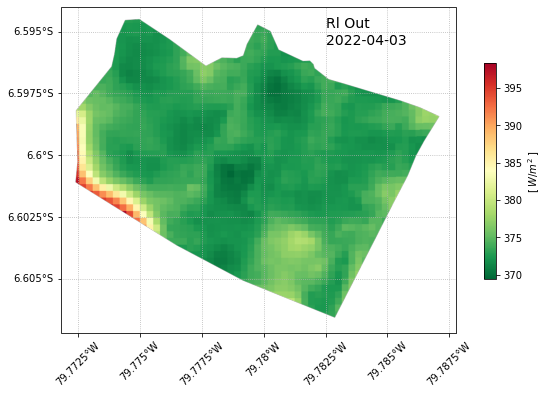

In [46]:
fig = plt.figure(figsize=(8,6))

zoom_region = [-79.787761, -6.607186, -79.771781, -6.593991]
vis_params_rlout = {'min':R_l_out_stats[0]['Mínimo'],
                    'max':R_l_out_stats[0]['Máximo'],
                    'palette':cmp.get_palette(cmap_name='RdYlGn_r')}

# plot the result with cartoee using a PlateCarre projection (default)
ax = cartoee.get_map(
    R_l_out.clip(predios_agricolas),
    region=zoom_region,
    vis_params=vis_params_rlout)

cb = cartoee.add_colorbar(ax, vis_params=vis_params_rlout, loc='right', label="$[\; W/m^2 \;]$")

cartoee.add_gridlines(ax, interval=0.0025, xtick_rotation=45, linestyle=":")

# ax.set_title(label='Albedo, 2022-04-03')#, fontsize=15)

ax.text(-79.7825, -6.5955, f'Rl Out \n{img_date}', fontsize=14)


plt.show()

### Flujo de calor del suelo $G$

Requiere antes haber ejecutado las celdas que producen el mapa de Radiación Neta.

In [24]:
# Expresión G/Rn
G_R_n = ts.expression(
    '(ts - 273.15)*(0.0038 + 0.0074*img_albedo)*(1 - 0.98*img_ndvi**4)',
    {'ts':ts,
     'img_albedo':img_albedo,
     'img_ndvi':img_ndvi.select('NDVI')
    }
).rename('G_R_n')

G_R_n_minmax = G_R_n.reduceRegion(ee.Reducer.minMax(), predios_agricolas, scale=30).values().reverse().getInfo()
print(f'G_R_n_minmax: {G_R_n_minmax}')

G_R_n_minmax: [0.045353383200824486, 0.09800043426499078]


In [26]:
# Obtener G
G = G_R_n.multiply(R_n.select('R_n')).rename('G')

# Rangos de G
G_minmax = G.reduceRegion(ee.Reducer.minMax(), scale=30).values().reverse().getInfo()
print(f'G_minmax: {G_minmax[0]:.5f} W/m² - {G_minmax[1]:.5f} W/m²')

G_minmax: 23.80478 W/m² - 75.60574 W/m²


In [48]:
# Estadísticas
G_stats = get_stats(G, predios_agricolas, 10, img_date)
G_stats

,0
Fecha,2022-04-03
Media,33.538075
Mediana,33.126149
Moda,32.875228
Desviación Estándar,3.351174
Mínimo,24.505224
Máximo,58.397584


In [51]:
# Visualización
Map = geemap.Map()
Map.centerObject(predios_agricolas, 16)

Map.addLayer(img_toa.clip(predios_bound), {'min':0,
                                           'max':0.3,
                                           'bands':['B4','B3','B2']}, 'RGB TOA')

vis_params_g = {'min':G_stats[0]['Mínimo'],
                'max':G_stats[0]['Máximo'],
                'palette':cmp.get_palette(cmap_name='RdYlGn_r')}

Map.addLayer(G.clip(predios_agricolas), vis_params_g, 'G') 
Map.add_colorbar(vis_params_g, label="G [W/m²]", orientation="vertical")

Map

Map(center=[-6.600211501838919, -79.78018963282872], controls=(WidgetControl(options=['position', 'transparent…

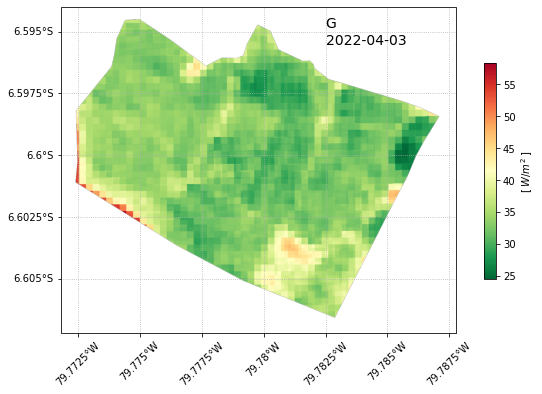

In [50]:
fig = plt.figure(figsize=(8,6))

zoom_region = [-79.787761, -6.607186, -79.771781, -6.593991]

# plot the result with cartoee using a PlateCarre projection (default)
ax = cartoee.get_map(
    G.clip(predios_agricolas),
    region=zoom_region,
    vis_params=vis_params_g
)

cb = cartoee.add_colorbar(ax, vis_params=vis_params_g, loc='right', label="$[\; W/m^2 \;]$")

cartoee.add_gridlines(ax, interval=0.0025, xtick_rotation=45, linestyle=":")

# ax.set_title(label='Albedo, 2022-04-03')#, fontsize=15)

ax.text(-79.7825, -6.5955, f'G \n{img_date}', fontsize=14)


plt.show()

### Flujo de calor sensible del aire $H$

Por adaptar de la libreta en colab...

## Prueba cartoee

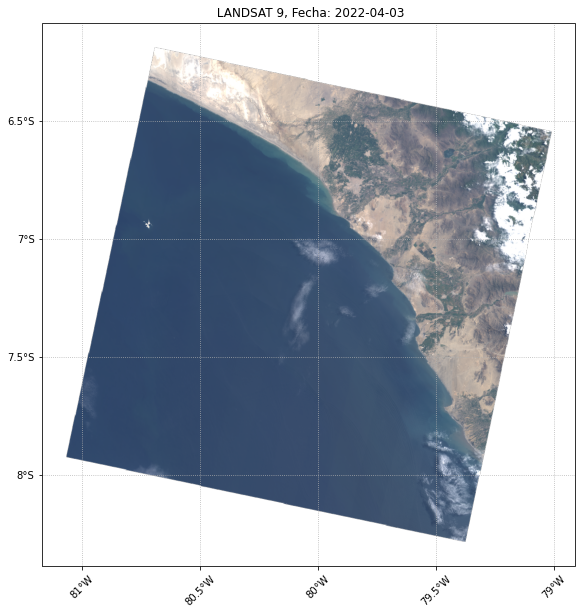

In [53]:
img = ee.Image('LANDSAT/LC09/C02/T1_TOA/LC09_010065_20220403')
img_date = img.date().format('YYYY-MM-dd').getInfo()

vis_params = {
    'min':0,
    'max':0.3,
    'bands':['B4','B3','B2']
}

fig = plt.figure(figsize=(10, 10))

# use cartoee to get a map
ax = cartoee.get_map(img, vis_params=vis)

# pad the view for some visual appeal (pad de padding)
cartoee.pad_view(ax)

ax.set_title(f' LANDSAT 9, Fecha: {img_date}')

# add the gridlines and specify that the xtick labels be rotated 45 degrees
cartoee.add_gridlines(ax, interval=0.5, xtick_rotation=45, linestyle=":")

show()

In [ ]:
# fig.savefig('prueba_toa.jpg')

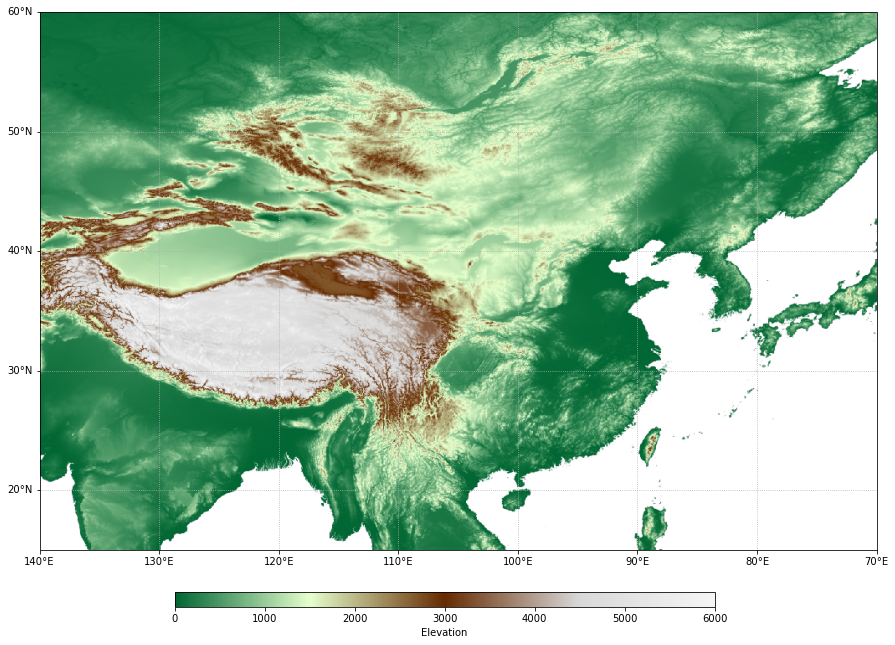

In [54]:
# get an image
srtm = ee.Image("CGIAR/SRTM90_V4")

palette = geemap.colormaps.palettes.dem

region = [70, 15, 140, 60]  # define bounding box to request data
# vis = {'min': 0, 'max': 5000}  # define visualization parameters for image
vis = {'palette': palette, 'min': 0.0, 'max': 6000.0, 'opacity': 1.0}

fig = plt.figure(figsize=(15, 10))

# use cartoee to get a map
ax = cartoee.get_map(srtm, region=region, vis_params=vis)

# add a colorbar to the map using the visualization params we passed to the map
cartoee.add_colorbar(
    ax,
    vis,
    loc="bottom",
    label="Elevation",
    orientation="horizontal",
    posOpts=[0.25, 0.05, 0.5, 0.02],
)

# add gridlines to the map at a specified interval
cartoee.add_gridlines(ax, interval=[10, 10], linestyle=":")

# add coastlines using the cartopy api
# ax.coastlines(color="red")

show()